/var/folders/1r/ph1yw3353jb398m67yh849kc0000gn/T/ipykernel_21988/2115249807.py:27: RuntimeWarning: divide by zero encountered in divide
  term = np.sqrt(l / (p * one_minus_p)) * ((C - R) / denom)


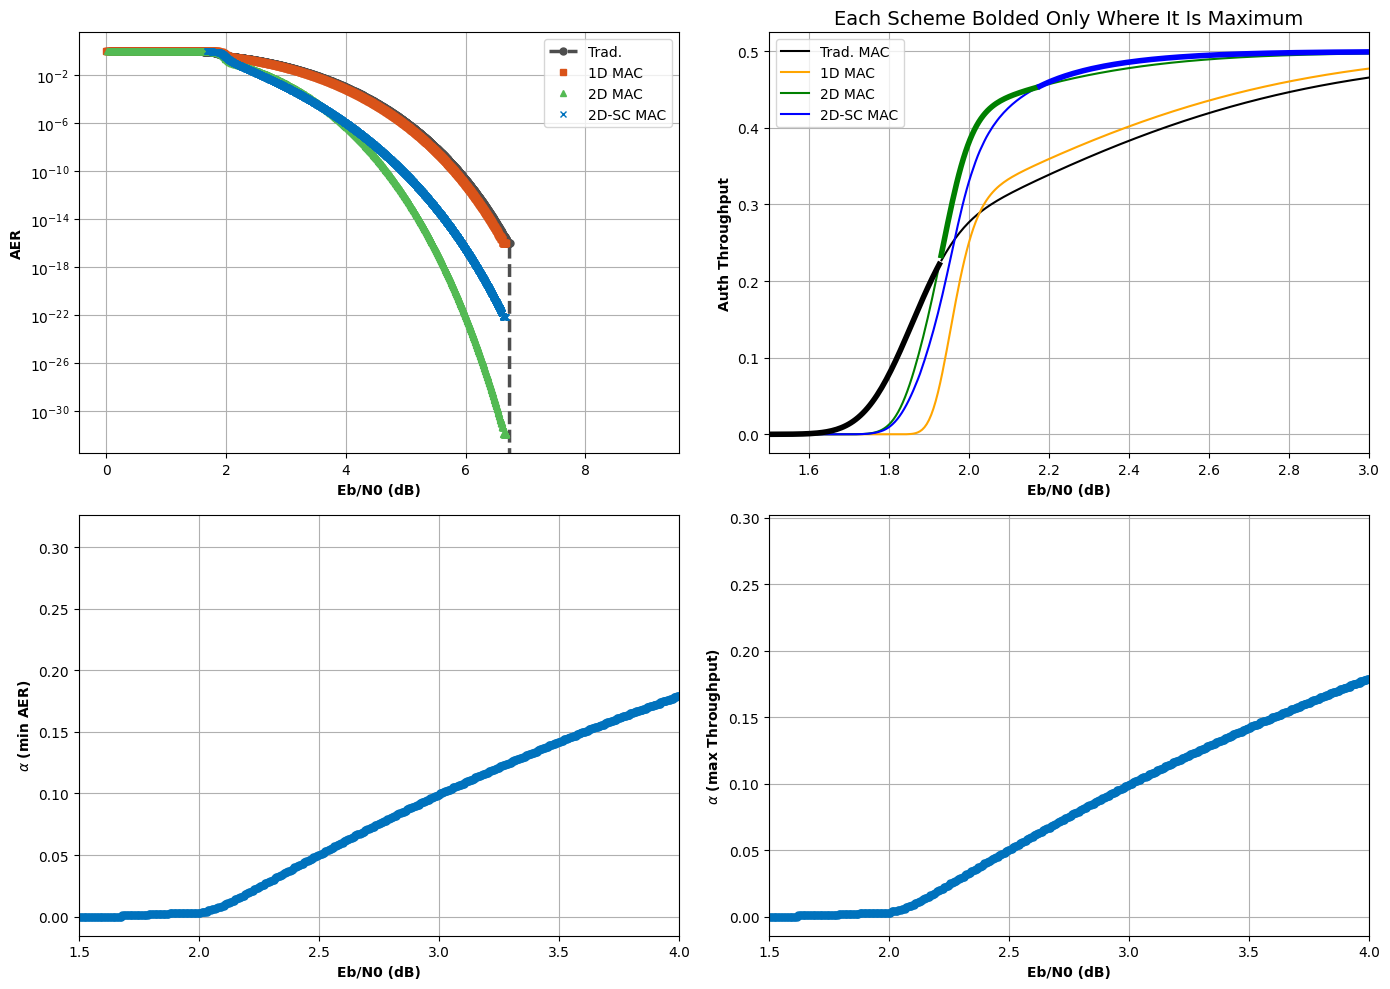

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Define Q-function
def qfunc(x):
    return 0.5 * erfc(x / np.sqrt(2))

# Basic SNR functions
def gam(txP, N0):
    return txP / N0

def gam_Super_tag(txP, N0, alpha):
    return (alpha * txP) / ((1 - alpha) * txP + N0)

def gam_Super_msg(txP, N0, alpha):
    return ((1 - alpha) * txP) / (alpha * txP + N0)

# Error rate function
def error_rate(l, R, snr):
    p = qfunc(np.sqrt(2 * snr))
    # Avoid log(0) issues by adding a very small number when needed.
    p = np.where(p == 0, 1e-15, p)
    one_minus_p = 1 - p
    C = 1 + p * np.log2(p) + one_minus_p * np.log2(one_minus_p)
    denom = np.log2(one_minus_p / p)
    term = np.sqrt(l / (p * one_minus_p)) * ((C - R) / denom)
    return qfunc(term)

# Functions for different processing schemes
def Pe_reg(l, P, R, N0):
    return error_rate(l, R, gam(P, N0))

def Pe_t_super(t, m, nc, P, R, N0, alpha):
    return error_rate(t, R * t / (nc * m), gam_Super_tag(P, N0, alpha))

def Pe_m_2D_super(m, R, P, N0, alpha):
    return error_rate(m, R, gam_Super_msg(P, N0, alpha))

# Energy per bit functions
def Em_trad(t, m, R, P):
    return P / R * (1 + t / m)

def Em_1D(t, m, R, P, nr):
    return P / R * (1 + t / (nr * m))

def Em_2D(t, m, R, P, nr, nc):
    return P / R * (1 + ((nr + nc) * t) / (nr * nc * m))

def Em_2D_super(t, m, R, P, nr):
    return P / R * (1 + t / (nr * m))

# Auxiliary functions for 2D schemes
def pr_2D(Pem, Pet, nr, nc):
    return (1 - ((1 - Pem)**(nc - 1) * (1 - Pet))) * (1 - ((1 - Pem)**(nr - 1) * (1 - Pet)))

def pr_2D_super(Pem, Pet, nr, nc, Pet_reg):
    return (1 - ((1 - Pem)**(nc - 1) * (1 - Pet))) * (1 - ((1 - Pem)**(nr - 1) * (1 - Pet_reg)))

# AER functions
def AER_trad(Pem, Pet):
    return 1 - ((1 - Pem) * (1 - Pet))

def AER_1D(Pem, Pet, nr):
    return 1 - (((1 - Pem)**nr) * (1 - Pet))

def AER_2D(Pem, Pet, nr, nc):
    return pr_2D(Pem, Pet, nr, nc) * (1 - Pem) + Pem

def AER_2D_super(Pem, Pet, nr, nc, Pet_reg):
    return pr_2D_super(Pem, Pet, nr, nc, Pet_reg) * (1 - Pem) + Pem

# Throughput functions
def AT_trad(Pem, Pet, m, t, R):
    return (R * m / (m + t)) * ((1 - Pet) * (1 - Pem))

def AT_1D(Pem, Pet, m, t, nr, R):
    return (R * nr * m / (nr * m + t)) * ((1 - Pet) * ((1 - Pem)**nr))

def AT_2D(Pem, Pet, m, t, nr, nc, R):
    return (R * nr * nc * m / (nr * nc * m + (nr + nc) * t)) * ((1 - pr_2D(Pem, Pet, nr, nc)) * (1 - Pem))

def AT_2D_super(Pem, Pet, m, t, nr, nc, Pet_reg, R):
    return (R * nr * m / (nr * m + t)) * ((1 - pr_2D_super(Pem, Pet, nr, nc, Pet_reg)) * (1 - Pem))

# ----- Set parameters -----
nr = 30       # number of rows
nc = 5        # number of columns
R = 0.5
m = 8196 / R
t = 128 / R
xlimit = [1.5, 4]
N0 = 100

# Define the range for Po and alpha
P_arr = np.arange(50, 400 + 1, .1)         # shape (nP,)
alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)  # shape (n_alpha,)

# Compute baseline error probabilities (with alpha = 0)
Pet = Pe_reg(t, P_arr, R, N0)  # shape (nP,)
Pem = Pe_reg(m, P_arr, R, N0)  # shape (nP,)

# Prepare expanded arrays for vectorized computation over P and alpha.
# P_exp: shape (nP, 1) and alpha_exp: shape (1, n_alpha)
P_exp = P_arr[:, None]
alpha_exp = alpha_arr[None, :]

# Compute 2D-super values over the grid of P and alpha
Pem_super_vec = Pe_m_2D_super(m, R, P_exp, N0, alpha_exp)  # shape (nP, n_alpha)
Pet_super_vec = Pe_t_super(t, m, nc, P_exp, R, N0, alpha_exp)  # shape (nP, n_alpha)

# Compute error rate and throughput for the 2D-super scheme.
# Note: The baseline Pet (computed with alpha=0) is broadcast along axis 1.
error_rate_2D_super_vec = AER_2D_super(Pem_super_vec, Pet_super_vec, nr, nc, Pet[:, None])
throughput_2D_super_vec   = AT_2D_super(Pem_super_vec, Pet_super_vec, m, t, nr, nc, Pet[:, None], R)

# For each Po value, select the optimal alpha values:
# For minimum AER, ignore entries where error_rate == 1 by replacing them with np.inf.
masked_AER = np.where(np.isclose(error_rate_2D_super_vec, 1), np.inf, error_rate_2D_super_vec)
min_AER = np.min(masked_AER, axis=1)
min_AER_idx = np.argmin(masked_AER, axis=1)
min_AER_alpha = alpha_arr[min_AER_idx]

# For maximum throughput, ignore zeros by replacing them with -infinity.
masked_throughput = np.where(np.isclose(throughput_2D_super_vec, 0), -np.inf, throughput_2D_super_vec)
max_Throu = np.max(masked_throughput, axis=1)
max_Throu_idx = np.argmax(masked_throughput, axis=1)
max_Throu_alpha = alpha_arr[max_Throu_idx]

# Compute energy, error rate and throughput for the other schemes (all vectorized over P_arr)
Eb_trad = Em_trad(t, m, R, P_arr)
error_rate_trad = AER_trad(Pem, Pet)
Throu_trad = AT_trad(Pem, Pet, m, t, R)

Eb_1D = Em_1D(t, m, R, P_arr, nr)
error_rate_1D = AER_1D(Pem, Pet, nr)
Throu_1D = AT_1D(Pem, Pet, m, t, nr, R)

Eb_2D = Em_2D(t, m, R, P_arr, nr, nc)
error_rate_2D = AER_2D(Pem, Pet, nr, nc)
Throu_2D = AT_2D(Pem, Pet, m, t, nr, nc, R)

Eb_2D_super = Em_2D_super(t, m, R, P_arr, nr)

# ----- Plotting -----
# Define color palette (each row is an RGB triplet)
lineColors = np.array([
    [0.3,    0.3,    0.3],    # gray
    [0.85,   0.325,  0.098],   # orange
    [0.325,  0.729,  0.325],   # green
    [0,      0.447,  0.741]    # blue
])

plt.figure(figsize=(14, 10))



# 1. Min AER vs Eb/N0
plt.subplot(2, 2, 1)
plt.semilogy(10 * np.log10(Eb_trad / N0), error_rate_trad,
             '--o', markersize=5, color=lineColors[0], linewidth=2.5, label="Trad.")
plt.semilogy(10 * np.log10(Eb_1D / N0), error_rate_1D,
             's', markersize=5, color=lineColors[1], linewidth=2.5, label="1D MAC")
plt.semilogy(10 * np.log10(Eb_2D / N0), error_rate_2D,
             '^', markersize=5, color=lineColors[2], linewidth=2.5, label="2D MAC")
plt.semilogy(10 * np.log10(Eb_2D_super / N0), min_AER,
             'x', markersize=5, color=lineColors[3], linewidth=2.5, label="2D-SC MAC")

# plt.xlim(xlimit)

plt.legend(loc='best')
plt.ylabel("AER", fontweight='bold')
plt.xlabel("Eb/N0 (dB)", fontweight='bold')
plt.grid(True)

# # 2. Max Throughput vs Eb/N0
# plt.subplot(2, 2, 2)
# plt.plot(10 * np.log10(Eb_trad / N0), Throu_trad,
#          '--o', markersize=5, color=lineColors[0], linewidth=2.5, label="Trad. MAC")
# plt.plot(10 * np.log10(Eb_1D / N0), Throu_1D,
#          's', markersize=5, color=lineColors[1], linewidth=2.5, label="1D MAC")
# plt.plot(10 * np.log10(Eb_2D / N0), Throu_2D,
#          '^', markersize=5, color=lineColors[2], linewidth=2.5, label="2D MAC")
# plt.plot(10 * np.log10(Eb_2D_super / N0), max_Throu,
#          'x', markersize=5, color=lineColors[3], linewidth=2.5, label="2D-SC MAC")

# plt.legend(loc='best')
# plt.ylabel("Auth Throughput", fontweight='bold')
# plt.xlabel("Eb/N0 (dB)", fontweight='bold')
# plt.xlim(xlimit)
# plt.grid(True)

x_trad      = 10 * np.log10(Eb_trad      / N0)
x_1D        = 10 * np.log10(Eb_1D        / N0)
x_2D        = 10 * np.log10(Eb_2D        / N0)
x_2D_super  = 10 * np.log10(Eb_2D_super  / N0)

y_trad      = Throu_trad
y_1D        = Throu_1D
y_2D        = Throu_2D
y_2D_super  = max_Throu   # 2D-SC MAC

def bold_thin(
    x_main, y_main,
    x_other1, y_other1,
    x_other2, y_other2,
    x_other3, y_other3
):
    """
    For each point in (x_main, y_main), interpolate the other three curves at x_main[i].
    Then check if y_main[i] is >= all interpolated values.
    Return two arrays: y_main_bold, y_main_thin
    - y_main_bold is y_main where it is max, else NaN
    - y_main_thin is y_main where it is not max, else NaN
    """
    y_main_bold = np.full_like(y_main, np.nan)
    y_main_thin = np.full_like(y_main, np.nan)

    for i in range(len(x_main)):
        xx = x_main[i]
        val_main = y_main[i]

        # Interpolate each other curve at x_main[i]
        val_o1 = np.interp(xx, x_other1, y_other1)
        val_o2 = np.interp(xx, x_other2, y_other2)
        val_o3 = np.interp(xx, x_other3, y_other3)

        # Check if current point is >= all other values
        if val_main >= val_o1 and val_main >= val_o2 and val_main >= val_o3:
            y_main_bold[i] = val_main
        else:
            y_main_thin[i] = val_main

    return y_main_bold, y_main_thin

# Create bold/thin arrays for each scheme
y_trad_bold, y_trad_thin     = bold_thin(x_trad,  y_trad,  x_1D,   y_1D,   x_2D,   y_2D,   x_2D_super, y_2D_super)
y_1D_bold,   y_1D_thin       = bold_thin(x_1D,    y_1D,    x_trad, y_trad, x_2D,   y_2D,   x_2D_super, y_2D_super)
y_2D_bold,   y_2D_thin       = bold_thin(x_2D,    y_2D,    x_trad, y_trad, x_1D,   y_1D,   x_2D_super, y_2D_super)
y_2Dsc_bold, y_2Dsc_thin     = bold_thin(x_2D_super,  y_2D_super,  x_trad, y_trad, x_1D,   y_1D,   x_2D,   y_2D)

# Now we can plot them: thin first, then bold on top
plt.subplot(2, 2, 2)

# Thin lines
plt.plot(x_trad,  y_trad_thin,   color='black',  linewidth=1.5, markersize=1, label="Trad. MAC")
plt.plot(x_1D,    y_1D_thin,       color='orange', linewidth=1.5, markersize=1, label="1D MAC")
plt.plot(x_2D,    y_2D_thin,       color='green',  linewidth=1.5, markersize=1, label="2D MAC")
plt.plot(x_2D_super,  y_2Dsc_thin,     color='blue',   linewidth=1.5, markersize=1, label="2D-SC MAC")

# Bold lines
# (No labels here to avoid duplicate legend entries.)
plt.plot(x_trad,  y_trad_bold, color='black',  linewidth=4.0, markersize=5)
plt.plot(x_1D,    y_1D_bold,   color='orange', linewidth=4.0, markersize=5)
plt.plot(x_2D,    y_2D_bold,   color='green',  linewidth=4.0, markersize=5)
plt.plot(x_2D_super,  y_2Dsc_bold,   color='blue',   linewidth=4.0, markersize=5)

plt.xlim([1.5,3])
plt.xlabel("Eb/N0 (dB)", fontweight='bold')
plt.ylabel("Auth Throughput", fontweight='bold')
plt.title("Each Scheme Bolded Only Where It Is Maximum", fontsize=14)
plt.grid(True)
plt.legend()





# 3. Alpha at Min AER vs Eb/N0
plt.subplot(2, 2, 3)
plt.plot(10 * np.log10(Eb_2D_super / N0), min_AER_alpha,
         linewidth=2.5, marker='o', markersize=5, color=lineColors[3])
plt.xlabel("Eb/N0 (dB)", fontweight='bold')
plt.ylabel(r'$\alpha$ (min AER)', fontweight='bold')
plt.xlim(xlimit)
plt.grid(True)

# 4. Alpha at Max Throughput vs Eb/N0
plt.subplot(2, 2, 4)
plt.plot(10 * np.log10(Eb_2D_super / N0), max_Throu_alpha,
         linewidth=2.5, marker='o', markersize=5, color=lineColors[3])
plt.xlabel("Eb/N0 (dB)", fontweight='bold')
plt.ylabel(r'$\alpha$ (max Throughput)', fontweight='bold')
plt.xlim(xlimit)
plt.grid(True)

plt.tight_layout()
plt.show()
